# This code is an attempt to create a model to classify the Malaria dataset. It contains images of the blood slides from healthy and infected blood samples of Malaria.

#  Find the dataset at https://ceb.nlm.nih.gov/repositories/malaria-datasets/

# Some Deep Learning Libraries and Frameworks used in this project are:
1. Keras
2. Tensorflow
3. Numpy
4. Pandas
5. Matplotlib

I am assuming that the readers have a fundamental understanding of Convolutional Neural Networks , Image Augmentation and Transfer Learning

Part 1 : Visualization , preprocessing and preparation of the data

In [1]:
# Importing the Best Trio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import os
import glob

directory = os.path.join ('./cell_images')

In [3]:
healthy_slides = os.path.join (directory , 'Uninfected')
infected_slides = os.path.join (directory , 'Parasitized')

In [4]:
healthy_files = glob.glob (healthy_slides + '/*.png' ) # Since we have the pictures in the png format
infected_files = glob.glob (infected_slides + '/*.png' )

In [5]:
print ('Total number of Image Slides of uninfected blood is ' + str (len (healthy_files)))
print ('Total number of Image Slides of infected blood is ' + str (len (infected_files)))

Total number of Image Slides of uninfected blood is 13779
Total number of Image Slides of infected blood is 13779


Stroing these files into a data frame in pandas

In [6]:
df = pd.DataFrame ({
    'file' : infected_files + healthy_files ,
    'label' : ['malaria'] * len (infected_files) + ['uninfected'] * len (healthy_files)
     }). sample (frac = 1 , random_state = 0 ). reset_index (drop = True)

In [7]:
# A peak into the data frame
df.head(3)

,file,label
0,./cell_images\Parasitized\C116P77ThinF_IMG_201...,malaria
1,./cell_images\Parasitized\C101P62ThinF_IMG_201...,malaria
2,./cell_images\Uninfected\C165P126ThinF_IMG_201...,uninfected


# Note : Due to the diversity of the slide images , it is very reasonable to assume that all the images are not the same size, unless some one already resized all of them. 


As we will see , all of the images are not of the same size. Due to the constraint of our model that 
we could only pass same sized images , I will resize them all to make it pass through the model

In [8]:
# Doing Train- Test Split
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(df['file'].values,
                                                                      df['label'].values, 
                                                                      test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.2, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nValidation Set:', Counter(val_labels), '\n Test Set:', Counter(test_labels))



(17636,) (4410,) (5512,)
Train: Counter({'uninfected': 8827, 'malaria': 8809}) 
Validation Set: Counter({'malaria': 2209, 'uninfected': 2201}) 
 Test Set: Counter({'malaria': 2761, 'uninfected': 2751})


In [9]:
type( train_files )


numpy.ndarray

In [10]:
import cv2
from concurrent import futures
import threading

IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  


Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_21: working on img num: 5000
ThreadPoolExecutor-0_23: working on img num: 10000
ThreadPoolExecutor-0_33: working on img num: 15000
ThreadPoolExecutor-0_7: working on img num: 17635

Loading Validation Images:
ThreadPoolExecutor-0_30: working on img num: 0
ThreadPoolExecutor-0_8: working on img num: 4409

Loading Test Images:
ThreadPoolExecutor-0_36: working on img num: 0
ThreadPoolExecutor-0_9: working on img num: 5000
ThreadPoolExecutor-0_36: working on img num: 5511


((17636, 125, 125, 3), (4410, 125, 125, 3), (5512, 125, 125, 3))

In [11]:
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

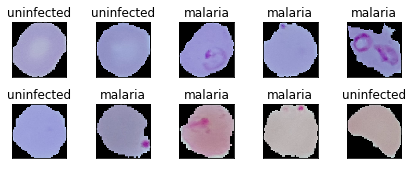

In [12]:
# Visualizing some of the samples in the training data

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (7 , 7))
n = 0 
for i in range(10):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(5 , 5 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [13]:
#Let us now model
import tensorflow as tf
import keras
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.960):
            print("\n Reached 96% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

Using TensorFlow backend.


In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

In [15]:
train_labels_enc

array([1, 0, 0, ..., 0, 0, 1])

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(125, 125, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.20),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(80, activation='relu'),
  tf.keras.layers.Dropout(0.25),  
  tf.keras.layers.Dense(1, activation='sigmoid')])


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 123, 123, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)            

In [20]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['acc'])

W0713 14:19:17.557295 45684 deprecation.py:323] From C:\Users\user pc\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=20,
                    epochs=30, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=[callbacks],
                    verbose=2)

Train on 17636 samples, validate on 4410 samples
Epoch 1/30
17636/17636 - 345s - loss: 0.5253 - acc: 0.7512 - val_loss: 0.3439 - val_acc: 0.9358
Epoch 2/30
17636/17636 - 329s - loss: 0.2779 - acc: 0.9174 - val_loss: 0.2861 - val_acc: 0.9478
Epoch 3/30
17636/17636 - 288s - loss: 0.2803 - acc: 0.9290 - val_loss: 0.3319 - val_acc: 0.9306
Epoch 4/30
17636/17636 - 226s - loss: 0.2931 - acc: 0.9260 - val_loss: 0.3259 - val_acc: 0.9426
Epoch 5/30
17636/17636 - 225s - loss: 0.2799 - acc: 0.9269 - val_loss: 0.3013 - val_acc: 0.9454
Epoch 6/30
17636/17636 - 224s - loss: 0.2781 - acc: 0.9290 - val_loss: 0.2806 - val_acc: 0.9460
Epoch 7/30
17636/17636 - 225s - loss: 0.2787 - acc: 0.9314 - val_loss: 0.2884 - val_acc: 0.9474
Epoch 8/30
17636/17636 - 225s - loss: 0.2768 - acc: 0.9329 - val_loss: 0.2752 - val_acc: 0.9497
Epoch 9/30
17636/17636 - 225s - loss: 0.2738 - acc: 0.9328 - val_loss: 0.2605 - val_acc: 0.9463
Epoch 10/30
17636/17636 - 224s - loss: 0.2575 - acc: 0.9359 - val_loss: 0.2663 - val_ac

In [ ]:
model.save('basic_cnn.h5')